In [1]:
from PIL import Image
import pandas as pd

In [2]:
im = Image.open("geomap.png")

In [3]:
from __future__ import print_function
print(im.format, im.size, im.mode)

x_size = im.size[0]
y_size = im.size[1]

PNG (1000, 1000) RGBA


In [4]:
im_data = list(im.getdata())

In [5]:
xy_tuples = []
for y in reversed(range(y_size)):
    for x in range(x_size):
        xy_tuples.append([x,y])
        
for index,pixel in enumerate(xy_tuples):
    pixel.append(im_data[index][0])

In [6]:
df = pd.DataFrame(xy_tuples, columns=['x','y','code'])

In [7]:
random_sampling = df.sample(frac=0.0002, replace=True)

In [8]:
regular_sampling = pd.DataFrame(columns=['x','y','code'])

In [9]:
x_int = 200
y_int = 200

row_list = []

for x in range(0, x_size, x_int):
    for y in range(0, y_size, y_int):
        row = df.loc[(df['x'] == x) & (df['y'] == y)]

        regular_sampling = regular_sampling.append(row, ignore_index=True)

In [10]:
random_sampling.head()

,x,y,code
781199,199,218,200
208847,847,791,100
819891,891,180,100
84616,616,915,100
243769,769,756,200


In [11]:
regular_sampling.head()

,x,y,code
0,0,0,0
1,0,200,0
2,0,400,0
3,0,600,0
4,0,800,0


In [12]:
full = pd.concat([random_sampling, regular_sampling])

In [13]:
f1 = full['code'] == 0
f2 = full['code'] == 100
f3 = full['code'] == 200
f = f1 | f2 | f3

In [ ]:
full = full[f]

In [14]:
full.to_csv('dataset.csv', index=False)

In [15]:
import pygeostat as gs

In [16]:
data = gs.DataFile(flname='dataset.csv', x='x', y='y', fltype='csv')

C:\Users\Roberto Rolo\Anaconda3\envs\geostat\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
C:\Users\Roberto Rolo\Anaconda3\envs\geostat\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Roberto Rolo\Anaconda3\envs\geostat\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\Roberto Rolo\Anaconda3\envs\geostat\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Roberto Rolo\Anaconda3\envs\geostat

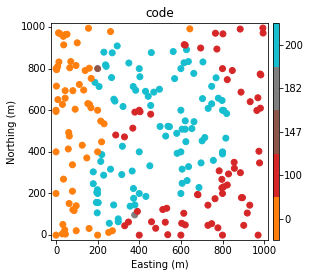

In [17]:
gs.locmap(data=data, x='x', y='y', z=None)